# Vividness Features: Experiment 3 Analysis

See Experiment 1 notebook for the full task description.  

***Relative to Experiment 2, the changes are:***
* Between-subjects design, focusing attention during encoding on either the **person** (group A) or the **place** (group B).  
* Participants are told to pay particular attention to the "specific visual details" of either the person/place and center the story around them/it.  
* After each encoding trial, they are asked to rate how successful they were in generating a story on a scale of 1-6.  

**Note. Due to no effect of the encoding manipulation on memory performance, data are collapsed across groups for assessing the relationship between memory vividness and memory attributes**

In [1]:
experiment = '3'

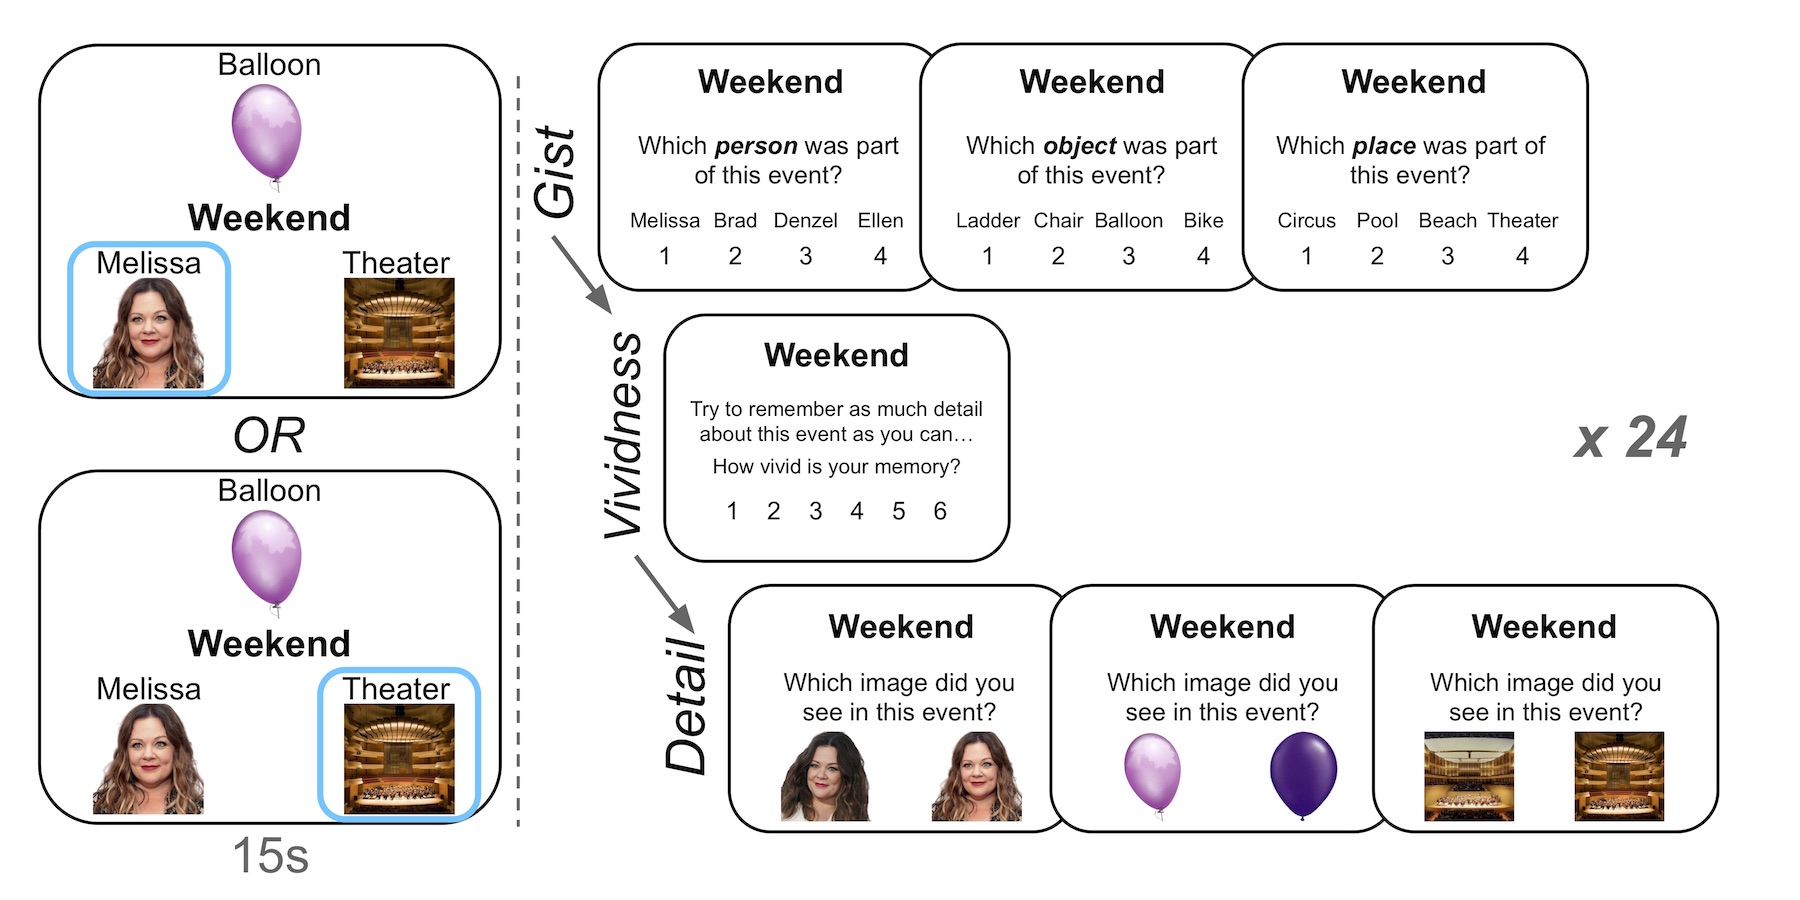

In [2]:
from IPython.display import Image
Image("Task-design_Exp3.jpg", width = 800)

# Sections

1. Data Import and Checks  
2. Memory Vividness  
3. Gist and Detail Memory  
4. **Attribute Relationships**  
***

# 1. Data Import and Checks

In [3]:
# load my functions:
import importlib, sys, os
sys.path.append(os.getcwd())

import vividness_analysis_functions
importlib.reload(vividness_analysis_functions)
from vividness_analysis_functions import *

In [4]:
import warnings
warnings.simplefilter('ignore')

# basic packages:
import glob
import pandas as pd
import numpy as np

# stats
import pingouin as pg

# visualisation
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import seaborn as sns

%matplotlib inline
set_matplotlib_formats('pdf', 'svg')

Find all csv data files:

In [5]:
data_dir = '../data/experiment' + experiment + '/'
print('Fetching data from:',data_dir)

my_files = np.sort(glob.glob(data_dir + "/*.csv")).tolist()

print('\nFound **',len(my_files),'** participant data files\n')

Fetching data from: ../data/experiment3/

Found ** 80 ** participant data files



Load and merge all subject data files into a single dataframe, with a column for group membership (A = person, B = place).  

In [6]:
print('Merging data files...')
my_list = [] 
for filename in my_files:

    df = pd.read_csv(filename, index_col=None, header=0)
    my_list.append(df)

# concatenate across subjects
my_data = pd.concat(my_list, axis=0, ignore_index=True)
print('\nData frame my_data created for all participants:')
my_data.head()

Merging data files...

Data frame my_data created for all participants:


,participant,expName,event_id,encoding.thisN,theme,object_label,person_label,place_label,resp_encSpace.rt,resp_enc_success.keys,...,resp_detailmem1.keys,resp_detailmem2.corr,resp_detailmem2.rt,resp_detailmem2.keys,resp_detailmem3.corr,resp_detailmem3.rt,resp_detailmem3.keys,familiarity.thisN,resp_facefam.keys,resp_facefam.rt
0,301,grpA,24.0,0.0,Family,Extinguisher,Ryan,Basketball,12.522765,4.0,...,1.0,1.0,2.196365,1.0,1.0,1.804995,2.0,6.0,1.0,2.404990
1,301,grpA,21.0,1.0,Home,Gloves,Angelina,Cabin,9.989410,6.0,...,1.0,1.0,1.936095,2.0,1.0,1.569005,2.0,11.0,1.0,1.482650
2,301,grpA,9.0,2.0,Shopping,Duster,Robert,Kitchen,10.956680,3.0,...,2.0,1.0,1.440780,1.0,0.0,4.433970,2.0,22.0,1.0,3.469200
3,301,grpA,2.0,3.0,Volunteer,Flowers,Jennifer,Waterfall,5.693990,4.0,...,2.0,1.0,1.730310,1.0,1.0,1.199925,1.0,20.0,1.0,3.586235
4,301,grpA,3.0,4.0,Music,Bike,Halle,Lighthouse,11.252960,5.0,...,2.0,1.0,2.492955,2.0,0.0,1.368225,1.0,8.0,2.0,1.799300


In [7]:
# rename expName (condition)
my_data.expName[my_data.expName == "grpA"] = "A_Person"
my_data.expName[my_data.expName == "grpB"] = "B_Place"

Double check that we have 24 events per subject:

In [8]:
ntrials = my_data.groupby('participant').count()
if any(ntrials["event_id"] != 24):
    print('Error: at least one participant does not have 24 trials')
else:
    print('All participants have 24 trials')

All participants have 24 trials


## Data Quality

a) Too fast RTs?  
b) High frequency of same key presses?  
c) Gist memory -- chance is 25%, is performance < 30%?  
d) Detail memory -- chance is 50%, is performance < 55%?  

In [9]:
# check data and return list of subject IDs to exclude:
my_data, exclude_subs = quality_check(my_data)


Number of subjects with median RT <= .75s -- 3 out of 80 subjects

Number of subjects with consistent key presses (> 75% same key) -- 0 out of 80 subjects

Number of subjects with gist memory <= 30% -- 4 out of 80 subjects

Number of subjects with detail memory <= 55% -- 6 out of 80 subjects

Removing subjects from my_data ....


### Vividness frequencies
Even though we don't need to exclude these subjects based on above criteria, I'm also adding in an option here to exclude subjects who do not have variability in their vividness responses (i.e. > 90% of responses are the same).

In [10]:
# run function to exclude subjects based on vividness distribution
# returns cleaned data and updated list of excluded subjects
my_data, exclude_subs = quality_vividness(my_data, exclude_subs)

Number of subjects with consistent vividness responses (> 90% same key) -- 1 out of 73 subjects

Removing subjects from my_data ....


In [11]:
#print filenames of excluded subjects to view actual ID numbers
print('Excluded IDs =', exclude_subs)
exclude_files = np.array([[i for i in my_files if str(j) in i] for j in exclude_subs]).reshape(len(exclude_subs)).tolist()

Excluded IDs = [303, 308, 314, 315, 317, 349, 373, 378]


In [12]:
perc_exclude = round((len(exclude_subs)/len(my_files))*100,2)
print('Total number of excluded subjects =',len(exclude_subs),'out of',len(my_files),'subjects','(',perc_exclude,'%)\n')

print('\n** FINAL ANALYSIS N =',len(my_data['participant'].unique()),'**\n\n')   

print('Final Ns per group =\n')
print(my_data.groupby('participant').first().expName.value_counts(),'\n')

Total number of excluded subjects = 8 out of 80 subjects ( 10.0 %)


** FINAL ANALYSIS N = 72 **


Final Ns per group =

A_Person    36
B_Place     36
Name: expName, dtype: int64 



For individual differences analyses, save a csv file with the file names of included subjects:

In [13]:
data_file = 'included_participants_exp' + experiment + '.csv'

include_files = pd.DataFrame([i for i in my_files if i not in exclude_files])
include_files.to_csv('../data/' + data_file, index=False, header=False)

print('\nSaved',len(include_files),'file names to:',data_file,'\n')


Saved 72 file names to: included_participants_exp3.csv 



## Encoding Responses

What is the distribution of encoding RTs from 0-15s across subjects when they responded?

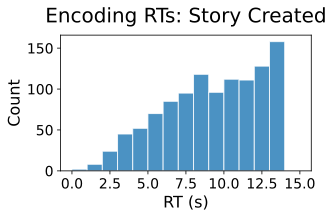

In [14]:
# show distribution of values:
my_data.hist(column='resp_encSpace.rt', bins=15,
            xlabelsize=14, ylabelsize=14, figsize=(4.5,2.5),
            edgecolor='white', alpha=.8,
            range=(0,15), align='mid')
plt.xlabel('RT (s)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Encoding RTs: Story Created', fontsize=20, y=1.05)
plt.grid(False)
plt.show()

In [15]:
# print mean and SE across subjects:
enc_rt = my_data.groupby('participant').mean().reset_index()[['participant','resp_encSpace.rt']]
enc_rt.agg(Mean=('resp_encSpace.rt', 'mean'),
           SE=('resp_encSpace.rt', 'sem'))

,resp_encSpace.rt
Mean,9.700284
SE,0.214246


In Experiment 3, we also asked participants to rate how successful they were in generating a story from 1-6. These ratings are plotted by group:

In [16]:
# group_by subject and calculate the mean -- box plot of subject values
sub_success = pd.DataFrame(my_data.groupby(['participant','expName']).mean()['resp_enc_success.keys'])
sub_success.columns=['mean success']

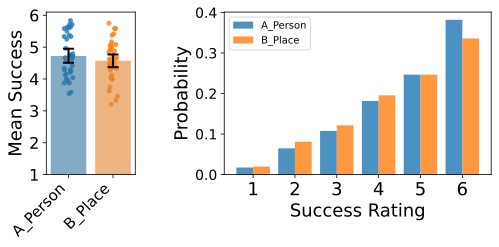

In [17]:
# plot:
fig, axes = plt.subplots(1, 2, figsize=(8,3), 
                         gridspec_kw={
                               'width_ratios': [1, 3],
                               'wspace': 0.5})

plt.axes(axes[0])
sns.barplot(y='mean success', x='expName',
            data=sub_success.reset_index(),
            alpha=.6, dodge=True, errcolor="k",
            errwidth=2, capsize=.2)
sns.stripplot(y='mean success', x='expName',
              data=sub_success.reset_index(),
              size=5, alpha=.8, zorder=0, jitter=.1)
plt.ylabel('Mean Success', fontsize=18)
plt.xlabel('')
plt.yticks(fontsize=16)
plt.xticks(fontsize=15, rotation=45, ha='right')
plt.grid(False)
plt.ylim(1,6.1)


# show distribution of values:
plt.axes(axes[1])
plt.hist([my_data.loc[my_data.expName == 'A_Person',"resp_enc_success.keys"],
         my_data.loc[my_data.expName == 'B_Place',"resp_enc_success.keys"]],
         bins=6, label=['A_Person','B_Place'],
         width=0.4, alpha=.8,
         range=(1,7), align='left', density=True)
plt.xlabel('Success Rating', fontsize=18)
plt.ylabel('Probability', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=18)
plt.title('')
plt.grid(False)
plt.legend(loc='upper left', fontsize=10)
plt.show()

Difference in story success between groups?

In [18]:
pg.pairwise_ttests(data=sub_success.reset_index(), dv='mean success', between='expName', subject='participant', effsize='cohen').round(4)

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,expName,A_Person,B_Place,False,True,0.9433,70.0,two-sided,0.3488,0.356,0.2223


In [19]:
sub_success.groupby('expName').agg(Mean=('mean success', 'mean'),
                                     SE=('mean success', 'sem'))

,Mean,SE
expName,,
A_Person,4.721065,0.112661
B_Place,4.575231,0.105863


# 2. Memory Vividness

Here, I'm plotting the distribution of vividness ratings across subjects and the mean per subject:

In [20]:
# group_by subject and calculate the mean -- box plot of subject values
sub_vividness = pd.DataFrame(my_data.groupby(['participant','expName']).mean()['resp_ret_vividness.keys'])
sub_vividness.columns=['mean vividness']

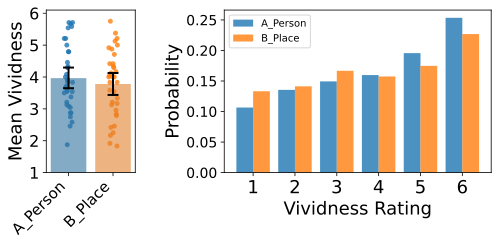

In [21]:
# plot:
fig, axes = plt.subplots(1, 2, figsize=(8,3), 
                         gridspec_kw={
                               'width_ratios': [1, 3],
                               'wspace': 0.5})

plt.axes(axes[0])
sns.barplot(y='mean vividness', x='expName',
            data=sub_vividness.reset_index(),
            alpha=.6, dodge=True, errcolor="k",
            errwidth=2, capsize=.2)
sns.stripplot(y='mean vividness', x='expName',
              data=sub_vividness.reset_index(),
              size=5, alpha=.8, zorder=0,
              jitter=.1)
plt.ylabel('Mean Vividness', fontsize=18)
plt.xlabel('')
plt.yticks(fontsize=16)
plt.xticks(fontsize=15, rotation=45, ha='right')
plt.grid(False)
plt.ylim(1,6.1)


# show distribution of values:
plt.axes(axes[1])
plt.hist([my_data.loc[my_data.expName == 'A_Person','resp_ret_vividness.keys'],
         my_data.loc[my_data.expName == 'B_Place','resp_ret_vividness.keys']],
         bins=6, label=['A_Person','B_Place'],
         width=0.4, alpha=.8,
         range=(1,7), align='left', density=True)
plt.xlabel('Vividness Rating', fontsize=18)
plt.ylabel('Probability', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=18)
plt.title('')
plt.grid(False)
plt.legend(loc='upper left', fontsize=10)
plt.show()

Difference in mean vividness between groups?

In [22]:
pg.pairwise_ttests(data=sub_vividness.reset_index(), dv='mean vividness', between='expName', subject='participant', effsize='cohen').round(4)

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,expName,A_Person,B_Place,False,True,0.757,70.0,two-sided,0.4516,0.311,0.1784


In [23]:
sub_vividness.groupby('expName').agg(Mean=('mean vividness', 'mean'),
                                     SE=('mean vividness', 'sem'))

,Mean,SE
expName,,
A_Person,3.962963,0.170619
B_Place,3.780093,0.171037


***Create df for subsequent analyses:***

In [24]:
# now merge vividness ratings with the objective memory attributes for subsequent analyes:
# produces 1 row per trial with columns for all 7 memory scores
memory_data = format_memory_data(my_data)

In [25]:
# add in group membership for experiment 3
groups = my_data.groupby('participant').first().reset_index()
memory_data = memory_data.merge(groups[['participant','expName']])

In [26]:
# finally, add in story succes ratings
my_data = my_data.rename(columns={"event_id": "event"})
memory_data = (memory_data.merge(my_data[['participant','expName','event','resp_enc_success.keys']])
               .rename(columns={'resp_enc_success.keys':'story_success',
                                'expName': 'group'})
              )
memory_data.head()

,participant,event,vividness,detail_object,detail_person,detail_place,gist_object,gist_person,gist_place,group,story_success
0,301,24.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,A_Person,4.0
1,301,21.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,A_Person,6.0
2,301,9.0,4.0,1.0,0.0,1.0,1.0,1.0,1.0,A_Person,3.0
3,301,2.0,4.0,1.0,1.0,1.0,1.0,0.0,1.0,A_Person,4.0
4,301,3.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,A_Person,5.0


# 3. Gist and Detail Memory

Proportion correct for identifying the person, place, and object associated with the theme - chance = 25% for gist and 50% for detail.  

## Gist

In [27]:
# calculate mean per subject and feature
this_data = memory_data.melt(id_vars=['participant','group','event'], value_vars=['gist_object','gist_person','gist_place'], var_name='type', value_name='score')
sub_gist = pd.DataFrame(this_data.groupby(['participant','group','type']).mean()[['score']]).reset_index()

In [28]:
# group averages by feature type:
pd.DataFrame(sub_gist.groupby(['group','type']).agg(Mean=('score', 'mean'),
                                                    SE=('score', 'sem')))

Mean        SE
group    type                           
A_Person gist_object  0.818287  0.028760
         gist_person  0.740741  0.031414
         gist_place   0.824074  0.028949
B_Place  gist_object  0.803241  0.030411
         gist_person  0.709491  0.032846
         gist_place   0.790509  0.030041

In [29]:
# ANOVA:
pg.mixed_anova(data=sub_gist, dv='score', within='type', subject='participant', between='group', effsize='n2').round(4)

,Source,SS,DF1,DF2,MS,F,p-unc,n2,eps
0,group,0.0383,1,70,0.0383,0.4247,0.5167,0.0052,NaN
1,type,0.3384,2,140,0.1692,34.0301,0.0000,0.0458,0.9285
2,Interaction,0.0037,2,140,0.0018,0.3686,0.6924,0.0005,NaN


## Detail

In [30]:
# calculate mean per subject and feature - not conditional on correct gist memory
this_data = memory_data.melt(id_vars=['participant','group','event'], value_vars=['detail_object','detail_person','detail_place'], var_name='type', value_name='score')
sub_detail = pd.DataFrame(this_data.groupby(['participant','group','type']).mean()[['score']]).reset_index()

In [31]:
# calculate group averages by feature type and print:
pd.DataFrame(sub_detail.groupby(['group','type']).agg(Mean=('score', 'mean'),
                                                      SE=('score', 'sem')))

Mean        SE
group    type                             
A_Person detail_object  0.791667  0.021960
         detail_person  0.771991  0.018596
         detail_place   0.737269  0.024444
B_Place  detail_object  0.734954  0.018571
         detail_person  0.750000  0.017802
         detail_place   0.732639  0.017282

In [32]:
# ANOVA and pairwise t-tests:
pg.mixed_anova(data=sub_detail, dv='score', within='type', subject='participant', between='group', effsize='n2').round(4)

,Source,SS,DF1,DF2,MS,F,p-unc,n2,eps
0,group,0.0417,1,70,0.0417,1.5271,0.2207,0.0134,NaN
1,type,0.0357,2,140,0.0179,2.2795,0.1061,0.0115,0.9682
2,Interaction,0.0253,2,140,0.0127,1.6165,0.2023,0.0081,NaN


**Now, for all subsequent analyses, I'm setting detail memory to 0 where gist = 0**  
*(the reasoning is that detail information can't influence vividness judgments if at least the gist wasn't recalled)*  

So, in "memory_data" gist is '1' if at least the gist is recalled, and detail is '1' if the gist *and* detail is recalled.

In [33]:
memory_measures = ["gist_object","gist_person","gist_place","detail_object","detail_person","detail_place"]

In [34]:
# copy for later gist-detail correlations
memory_data_orig = memory_data.copy()

# detail = 0 where gist = 0
memory_data.detail_object[memory_data.gist_object == 0] = 0
memory_data.detail_person[memory_data.gist_person == 0] = 0
memory_data.detail_place[memory_data.gist_place == 0] = 0

# finally, create summary measure
memory_data["total"] = memory_data[memory_measures].sum(axis=1)
memory_data.head()

,participant,event,vividness,detail_object,detail_person,detail_place,gist_object,gist_person,gist_place,group,story_success,total
0,301,24.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,A_Person,4.0,6.0
1,301,21.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,A_Person,6.0,2.0
2,301,9.0,4.0,1.0,0.0,1.0,1.0,1.0,1.0,A_Person,3.0,5.0
3,301,2.0,4.0,1.0,0.0,1.0,1.0,0.0,1.0,A_Person,4.0,4.0
4,301,3.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,A_Person,5.0,5.0


Now with detail conditional upon gist, how many features do participants recall from each memory cue?

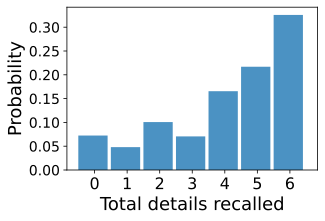

In [35]:
# plot distribution of total memory scores per event (0-6)
memory_data.hist(column='total', bins=7,
                 xlabelsize=16, ylabelsize=14, figsize=(4.5,3),
                 width=0.9, alpha=.8,
                 range=(0,7), align='left', density=True)
plt.xlabel('Total details recalled', fontsize=18)
plt.ylabel('Probability', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=16)
plt.title('')
plt.grid(False)
plt.show()

# 4. Vividness-Attribute Relationships

I start by checking that memory vividness is actually correlated with the total number of attributes recalled.

Next, I calculate the within-subject correlation between each individual attribute and memory vividness, checking the independent influence of gist and detail memory on vividness ratings.

***Note that, because group had no effect on memory performance (i.e. the encoding manipulation "failed"), data are collapsed across groups (for a total N of 72) for subsequent analyses***

## Story Success

In [36]:
# run correlation, fetching r per subject and feature:
cor_params = vividness_correlations(memory_data, ['story_success'])

# fisher z transform between stats
cor_params["z"] = np.arctanh(cor_params.story_success.astype('float'))

pg.ttest(cor_params.z, 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.5687,71,two-sided,0.0006,"[0.05, 0.16]",0.4206,37.229,0.9406


In [37]:
# group average
pd.DataFrame(cor_params.agg(Mean=('z', 'mean'),
                            SE=('z', 'sem')))

,z
Mean,0.102078
SE,0.028603


## Total Detail

In [38]:
# run correlation, fetching r per subject and feature:
features = ['total']
cor_params = vividness_correlations(memory_data, features)

# fisher z transform between stats
cor_params["z"] = np.arctanh(cor_params.total.astype('float'))

pg.ttest(cor_params.z, 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,14.9387,71,two-sided,0.0,"[0.51, 0.66]",1.7605,3.151e+20,1.0


In [39]:
# group average
pd.DataFrame(cor_params.agg(Mean=('z', 'mean'),
                            SE=('z', 'sem')))

,z
Mean,0.585640
SE,0.039203


## Content x Specificity

*How does the specificity of retrieval influence memory vividness, and is this modulated by content?*

In [40]:
# calculate gist-specific correlations
cor_params_gist = vividness_correlations(memory_data, ["gist_object","gist_person","gist_place"]).melt(id_vars="index", var_name="content", value_name="gist")
cor_params_gist['content'].replace({"gist_object":"object", "gist_person":"person", "gist_place":"place"}, inplace=True)

In [41]:
# calculate detail-specific correlations (where gist = 1)
cor_detail_object = vividness_correlations(memory_data[memory_data.gist_object == 1], ["detail_object"])
cor_detail_person = vividness_correlations(memory_data[memory_data.gist_person == 1], ["detail_person"])
cor_detail_place = vividness_correlations(memory_data[memory_data.gist_place == 1], ["detail_place"])

# merge detail to single df:
cor_params_detail = cor_detail_object.merge(cor_detail_person)
cor_params_detail = cor_params_detail.merge(cor_detail_place).melt(id_vars='index', var_name="content", value_name="detail")
cor_params_detail['content'].replace({"detail_object":"object", "detail_person":"person", "detail_place":"place"}, inplace=True)

In [42]:
# merge gist and detail to single df:
cor_params = cor_params_detail.merge(cor_params_gist, how="outer")
cor_params = cor_params.melt(id_vars=["index","content"], var_name="specificity", value_name="r")

In [43]:
# fisher z transform before stats
cor_params["z"] = np.arctanh(cor_params.r.astype('float'))
cor_params.head()

,index,content,specificity,r,z
0,301,object,detail,-0.167542,-0.169136
1,302,object,detail,-0.211807,-0.215063
2,304,object,detail,0.366483,0.384355
3,305,object,detail,-0.321005,-0.332768
4,306,object,detail,0.0508723,0.050916


In [44]:
# one-sample t-tests:
tests = []
for c in cor_params.content.unique():
    for s in cor_params.specificity.unique():
        t = pg.ttest(cor_params.loc[(cor_params.content == c) & (cor_params.specificity == s),"z"], 0).round(4)
        t['content'] = c
        t['specificity'] = s
        tests.append(t)

tests = pd.concat(tests)

# add bonferroni correction:
tests["p-bonf"] = pg.multicomp(tests["p-val"].tolist(), alpha=.05, method="bonf")[1]
tests

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,content,specificity,p-bonf
T-test,4.4374,71,two-sided,0.0000,"[0.07, 0.18]",0.5230,579.809,0.9922,object,detail,0.0000
T-test,13.5116,71,two-sided,0.0000,"[0.33, 0.45]",1.5924,1.78e+18,1.0000,object,gist,0.0000
T-test,3.0221,71,two-sided,0.0035,"[0.03, 0.16]",0.3562,8.213,0.8464,person,detail,0.0210
T-test,11.8521,71,two-sided,0.0000,"[0.34, 0.47]",1.3968,3.202e+15,1.0000,person,gist,0.0000
T-test,3.3843,71,two-sided,0.0012,"[0.05, 0.2]",0.3988,21.9,0.9159,place,detail,0.0072
T-test,14.6145,71,two-sided,0.0000,"[0.36, 0.47]",1.7223,9.934e+19,1.0000,place,gist,0.0000


In [45]:
# repeated measures anova:
pg.rm_anova(data=cor_params, dv='z', within=['content','specificity'], subject="index", effsize="n2", detailed=True).round(4)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,n2,eps
0,content,0.0308,2,142,0.0154,0.2502,0.7790,0.7660,0.0010,0.9424
1,specificity,8.9346,1,71,8.9346,97.9360,0.0000,0.0000,0.2935,1.0000
2,content * specificity,0.0310,2,142,0.0155,0.3527,0.7034,0.6958,0.0010,0.9648


In [46]:
# plot:
cor_params = cor_params.pivot(index='index', columns=['specificity','content'], values='r')
cor_params.columns = cor_params.columns.map('_'.join)
cor_params = cor_params[memory_measures].melt()

In [47]:
pal = sns.color_palette("Set2")
colors = pal.as_hex()[:3]

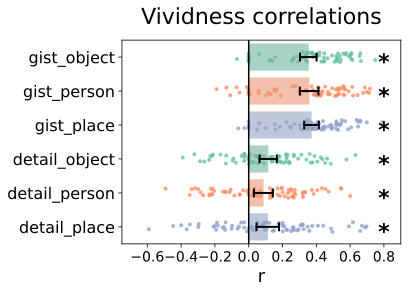

In [48]:
plt.figure(figsize=(5,3.75))

sns.barplot(data=cor_params, y='variable', x='value',
            palette=sns.color_palette(colors + colors),
            alpha=.6, dodge=True, 
            errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(data=cor_params, y='variable', x='value',
              palette=sns.color_palette(colors + colors),
              dodge=True, size=4, zorder=0, alpha=.8, jitter=.15)

# statistical annotation
plt.text(.8, 0.5, "*", ha='center', va='bottom', color="k", 
         fontsize=22, fontweight='bold')
plt.text(.8, 1.5, "*", ha='center', va='bottom', color="k", 
         fontsize=22, fontweight='bold')
plt.text(.8, 2.5, "*", ha='center', va='bottom', color="k", 
         fontsize=22, fontweight='bold')
plt.text(.8, 3.5, "*", ha='center', va='bottom', color="k", 
         fontsize=22, fontweight='bold')
plt.text(.8, 4.5, "*", ha='center', va='bottom', color="k", 
         fontsize=22, fontweight='bold')
plt.text(.8, 5.5, "*", ha='center', va='bottom', color="k", 
         fontsize=22, fontweight='bold')

plt.xlabel('r', fontsize=18)
plt.xticks(fontsize=14)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlim([-.75, .9])
plt.title('Vividness correlations', fontsize=22, y=1.05)

# save 
plt.savefig("plots/vividness_correlations_experiment" + experiment + ".pdf", bbox_inches = 'tight')
plt.show()

### Full Correlation Matrix

In addition to correlations with vividness, here I'm showing the full 6 x 6 correlation matrix of trial-wise correlations.  
Note that this uses the original data (so detail memory can be correct even if gist is incorrect).  

In [49]:
# correlations by subject
my_list = []
for s in memory_data_orig['participant'].unique():
    
    sub_data = memory_data_orig[memory_data_orig['participant'] == s]  
    # correlate and fisher z transform
    sub_cors = sub_data[memory_measures].corr(method="spearman")
    sub_cors[np.round(np.abs(sub_cors),1) == 1] = np.nan
    sub_cors = np.arctanh(sub_cors)
    #append
    my_list.append(sub_cors)
    
memory_cors = np.dstack(tuple(my_list))
memory_cors[np.isnan(memory_cors)] = 0
print('Dimensions of var x var x subject memory correlations = ' + str(memory_cors.shape))

Dimensions of var x var x subject memory correlations = (6, 6, 72)


group average:

In [50]:
# transforming subject z back to spearman at group level
group_cors = np.tanh(np.nanmean(memory_cors, axis=2))
np.fill_diagonal(group_cors, 0)

# convert to df to name with memory variables
group_cors = pd.DataFrame(group_cors, columns=memory_measures, index=memory_measures)

#get significance and labels
p_mask, labels = fetch_sig_cors(memory_cors, group_cors, sym=True)

heat map (* = p < .05 bonferroni-corrected)

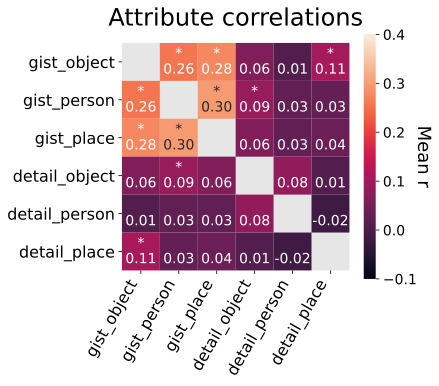

In [51]:
plot_cor_heatmap(group_cors, l = labels, cmap = 'rocket', title = 'Attribute correlations')
# save 
plt.savefig("plots/attribute_correlations_experiment" + experiment + ".pdf", bbox_inches = 'tight')
plt.show()

### Predictive Model

Finally, using the 6 individual attributes, can we predict the vividness of a new memory?

Here, I'm using linear regression, with cross-validation -- data from across all subjects (so 24 events * Nsubs).  
I'm starting by including all of the features, and then I'll take the least important one out and repeat the process again until there is just 1 predictor left.

**The model returned is that with the highest *out-of-sample* R-squared value**

In [52]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.linear_model import LinearRegression

In [53]:
y = memory_data['vividness']
X = memory_data[memory_measures]

print('Total number of events =', memory_data.shape[0],'\n')

Total number of events = 1728 



In [54]:
# specifiy 10 folds, over 5 repetitions
kf = RepeatedStratifiedKFold(random_state=1, n_splits=10, n_repeats=5)

In [55]:
included_features = X.columns.tolist()
X_orig = X

model_weights = []
model_scores = []
for m in range(len(included_features)):
    
    X = X_orig[included_features]
    
    # run cross-validation (note. LR() adds intercept by default):
    models = cross_validate(LinearRegression(), X, y, cv=kf, scoring='r2', return_estimator=True)
    
    # first, let's store the r-squared scores, and show the average:
    scores = models['test_score']
    model_scores.append(scores)
    print('Features =',included_features)
    print('R-squared =',np.round(np.mean(scores),5),'( +/-',np.round(np.std(scores),5),')\n')
    
    # find the weights and drop the lowest feature
    features = []
    for idx, model in enumerate(models['estimator']):
        features.append(pd.DataFrame(model.coef_,
                                     index = included_features, columns=['model_' + str(idx)]))
    weights = pd.concat(features, axis=1, ignore_index=True).transpose()
    model_weights.append(weights) #beta values
    
    lowest_feature = weights.mean().sort_values().index[0]
    included_features.remove(lowest_feature)

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place']
R-squared = 0.4137 ( +/- 0.05335 )

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person']
R-squared = 0.41118 ( +/- 0.05367 )

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object']
R-squared = 0.40741 ( +/- 0.05447 )

Features = ['gist_object', 'gist_person', 'gist_place']
R-squared = 0.40104 ( +/- 0.05274 )

Features = ['gist_object', 'gist_place']
R-squared = 0.34396 ( +/- 0.05431 )

Features = ['gist_object']
R-squared = 0.24643 ( +/- 0.0552 )



In [56]:
print('\n*BEST MODEL*:\n')

rsquared_values = pd.DataFrame(model_scores).mean(axis=1)
best_model = np.where(rsquared_values == rsquared_values.max())[0].tolist()[0]

print('R-squared =',np.round(rsquared_values[best_model],4))
print('Features =',model_weights[best_model].columns.to_list(),'\n')


*BEST MODEL*:

R-squared = 0.4137
Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place'] 



Remember here that gist amounts to gist without the detail, and detail = gist *and* detail

Plot average weights from the full model

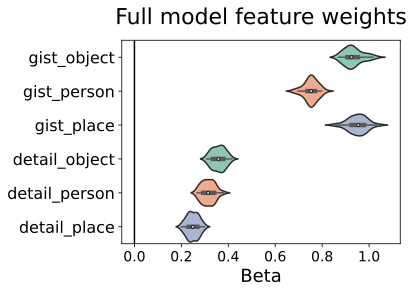

In [57]:
plt.figure(figsize=(5,3.75))
g = sns.violinplot(data=model_weights[0].melt(), 
            y='variable', x='value',
            palette=sns.color_palette(colors + colors), width=0.95)
for violin in g.collections:
        violin.set_alpha(0.8)
        violin.set_edgecolor('k')
plt.xlabel('Beta', fontsize=18)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xticks(fontsize=14)
plt.title('Full model feature weights', fontsize=22, y=1.05)

# save 
plt.savefig("plots/feature_weights_experiment" + experiment + ".pdf", bbox_inches = 'tight')
plt.show()